In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import norm
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from sklearn.metrics import average_precision_score

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
torch.manual_seed(1);

## Read data

In [3]:
import os
SEQ_LEN = 64
IM_SIZE = 28

In [4]:
def read_img_sequences(path_to_folder, size=200):
    curr_size = 0
    data = []
    labels = []
    
    for sequence_folder in os.listdir(path_to_folder):
        curr_size += 1
        full_sequence_folder = os.path.join(path_to_folder, sequence_folder)
        sequence_img = [None] * SEQ_LEN
        sequence_labels = [None] * SEQ_LEN
        
        for img_path in os.listdir(full_sequence_folder):
            # -3: drop .pt
            im_index, label = img_path[:-3].split('_')
            im_index = int(im_index)
            label = int(label)

            full_path_to_img = os.path.join(full_sequence_folder, img_path)
            # load image and reshape to vector
            img = torch.load(full_path_to_img).view(IM_SIZE * IM_SIZE).detach().cpu().numpy()
            sequence_img[im_index] = img
            sequence_labels[im_index] = label
        data.append(sequence_img)
        labels.append(sequence_labels)
        if curr_size ==  size:
            break
    return data, labels

In [5]:
anomaly_data, anomaly_labels = read_img_sequences('data_5_in_6/img_ts_anomaly/')
normal_data, normal_labels = read_img_sequences('data_5_in_6/img_ts_normal/')

In [6]:
digit_1 = 5
digit_2 = 6

In [7]:
all_data = np.vstack((anomaly_data, normal_data))
all_labels = np.vstack((anomaly_labels, normal_labels))

all_labels = (all_labels == digit_2).astype(int)

In [8]:
train_data, test_data, train_labels, test_labels = train_test_split(all_data, all_labels, 
                                                                    test_size=0.4, shuffle=True,
                                                                    random_state=42)

test_data, val_data, test_labels, val_labels = train_test_split(test_data, test_labels, 
                                                                test_size=0.5, shuffle=True,
                                                                random_state=42)

## Loss function

In [9]:
device = torch.device('cuda')

In [10]:
def loss_delay_detection_2(p_slice):
    n = p_slice.size(0)
    prod = torch.ones(n).to(device)
    p_slice = p_slice.to(device)
    prod[1:] -= p_slice[:-1]
    cumprod = torch.cumprod(prod, dim=0).to(device)
    loss = torch.arange(1, n + 1).to(device) * p_slice * cumprod
    loss = torch.sum(loss)
    return loss


def loss_delay_detection(p_slice, w):
    n = p_slice.size(0) 
    prod = torch.ones(n).to(device)
    p_slice = p_slice.to(device)
    
    prod[1:] -= p_slice[:-1].to(device)
    cumprod = torch.cumprod(prod, dim=0).to(device)
    # TODO drop either n or w
    loss = (torch.arange(1, n + 1).to(device) * p_slice * cumprod 
            + (w + 1) * torch.prod(prod[1:]) * (1 - p_slice[-1]))
    loss = torch.sum(loss)
    return loss

def loss_false_alarms(p_slice):
    length = len(p_slice)
    loss = 0
    
    start_ind = 0
    end_ind = 0
    
    while end_ind < length:
        start_ind = end_ind - 1
        if start_ind < 0:
            start_ind = 0
        end_ind = np.random.randint(start_ind, length + 2)
        if end_ind == start_ind:
            end_ind = end_ind + 1
        loss += 1 - loss_delay_detection_2(p_slice[start_ind: end_ind + 1])    
    #loss += 1 - loss_delay_detection_2(p_slice[start_ind: length])            
    loss = torch.sum(loss)
    return loss

In [11]:
loss_delay_detection(torch.Tensor([0.9, 0.1, 0.3]), 3)

tensor(1.7570, device='cuda:0')

In [12]:
class CustomLoss(nn.Module):
    
    def __init__(self):
        super(CustomLoss, self).__init__()
        
    def forward(self, outputs, labels):
        loss = torch.zeros(labels.size(0))
        for i, label in enumerate(labels):
            ind = torch.where(label != label[0])[0]
            if ind.size()[0] == 0:
                loss[i] = loss_false_alarms(outputs[i, :])
            else:
                w = 16
                alpha = 0.5
                loss[i] = (alpha * loss_delay_detection(outputs[i, ind[0]:(ind[0] + w)], w) + 
                           (1 - alpha) * loss_false_alarms(outputs[i, :ind[0]]))
        loss = torch.mean(loss)
        return loss

In [13]:
# input data parameters
input_size = IM_SIZE * IM_SIZE
output_size = SEQ_LEN
seq_len = SEQ_LEN

# model hyperparameters
hidden_dim = 100
n_layers = 2
num_workers = 1
learning_rate = 1e-3

batch_size = 64

In [14]:
def prepare_loader(data, labels, seq_len, input_size, batch_size, shuffle=True, num_workers=1):
    data = torch.FloatTensor(data)
    labels = torch.FloatTensor(labels)
    data = data.view(-1, seq_len, input_size)
    labels = labels.view(-1, seq_len)

    all_data = TensorDataset(data, labels) 
    data_loader = DataLoader(all_data, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
    
    return data_loader

In [15]:
device = torch.device("cuda:1")

In [16]:
train_loader = prepare_loader(train_data, train_labels, seq_len, input_size, batch_size)
val_loader = prepare_loader(val_data, val_labels, seq_len, input_size, batch_size)
test_loader = prepare_loader(test_data, test_labels, seq_len, input_size, batch_size)

In [17]:
def train_model(model, loss_function, epochs=100, print_every=5, LSTM_flag = True):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    
    valid_loss_min = np.Inf

    loss_list = []
    acc_list = []
    overall_val_loss_list = []
    counter = 0
    model.train()

    out_list = []
    labels_list = []

    model.train()
    for i in range(epochs):
        # for inputs, labels in tqdm(train_loader):
        for inputs, labels in train_loader:
            if inputs.shape[0] < batch_size:
                break

            counter += 1
            inputs, labels = inputs.to(device), labels.to(device)  

            if LSTM_flag:
                h = model.init_hidden(batch_size)
                h = tuple([e.data for e in h])
                output, h = model(inputs, h)
            else:
                output = model(inputs)

            loss = loss_function(output.squeeze(), labels.float())
            loss_list += [loss.cpu().clone().detach()]
            accuracy = (output > 0.5).long() == labels
            acc_list += [accuracy.cpu().detach().float().mean()]
            out_list.append(output.cpu().detach().float())
            labels_list.append(labels.cpu().detach().float())

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            if counter%print_every == 0:
                val_losses = []
                val_outputs = []
                model.eval()
                for val_inputs, val_labels in val_loader:
                    if val_inputs.shape[0] < batch_size:
                        break
                    val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)

                    if LSTM_flag:
                        val_h = model.init_hidden(batch_size)
                        val_h = tuple([each.data for each in val_h])
                        val_out, val_h = model(val_inputs, val_h)
                    else:
                        val_out = model(val_inputs)
                        
                    val_loss = loss_function(val_out.squeeze(), val_labels.float())
                    val_losses.append(val_loss.item())
                    val_outputs += [val_out.cpu().clone().detach()]

                val_outputs_one = torch.cat(val_outputs, 0)

                overall_val_loss_list.append(np.mean(val_losses))

                model.train()
                print("Epoch: {}/{}...".format(i+1, epochs),
                      "Step: {}...".format(counter),
                      "Loss: {:.6f}...".format(loss.item()),
                      "Val Loss: {:.6f}".format(np.mean(val_losses)))
    return model, (loss_list, acc_list, overall_val_loss_list)

## LSTM Model

In [18]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers, drop_prob=0.5):
        
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim        
        # if batch_first, than shape of lstm_in: [batch_size, seq_len, input_size]
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.linear_1 = nn.Linear(hidden_dim, hidden_dim//2)
        self.linear_2 = nn.Linear(hidden_dim//2, 1)
        self.activation = nn.Sigmoid()
        self.relu = nn.ReLU()
        
    def forward(self, input_seq, hidden):
        batch_size = input_seq.size(0)
        lstm_out, hidden = self.lstm(input_seq, hidden)  
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)      
        out = self.linear_1(lstm_out)
        out = self.dropout(out)
        out = self.relu(out)
        out = self.linear_2(out)
        out = self.activation(out)
        out = out.view(batch_size, -1)

        return out, hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

In [19]:
model_LSTM_custom = LSTM(input_size=input_size, output_size=output_size, hidden_dim=hidden_dim, n_layers=n_layers)
loss_function = CustomLoss()
model_LSTM_custom.to(device)

LSTM(
  (lstm): LSTM(784, 100, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (linear_1): Linear(in_features=100, out_features=50, bias=True)
  (linear_2): Linear(in_features=50, out_features=1, bias=True)
  (activation): Sigmoid()
  (relu): ReLU()
)

In [20]:
model_LSTM_custom, (loss_list, acc_list, 
                    overall_val_loss_list) = train_model(model_LSTM_custom, loss_function, 60, 5, LSTM_flag=True)

Epoch: 2/60... Step: 5... Loss: -2.246482... Val Loss: -2.259223
Epoch: 4/60... Step: 10... Loss: -2.579802... Val Loss: -2.778223
Epoch: 5/60... Step: 15... Loss: -3.005187... Val Loss: -3.333171
Epoch: 7/60... Step: 20... Loss: -4.861907... Val Loss: -4.933771
Epoch: 9/60... Step: 25... Loss: -5.326499... Val Loss: -6.631290
Epoch: 10/60... Step: 30... Loss: -7.542007... Val Loss: -7.515686
Epoch: 12/60... Step: 35... Loss: -6.740829... Val Loss: -7.778805
Epoch: 14/60... Step: 40... Loss: -8.987364... Val Loss: -8.538397
Epoch: 15/60... Step: 45... Loss: -9.595192... Val Loss: -10.382303
Epoch: 17/60... Step: 50... Loss: -9.018793... Val Loss: -11.032455
Epoch: 19/60... Step: 55... Loss: -13.050194... Val Loss: -10.862600
Epoch: 20/60... Step: 60... Loss: -12.362104... Val Loss: -13.125092
Epoch: 22/60... Step: 65... Loss: -11.777502... Val Loss: -13.148105
Epoch: 24/60... Step: 70... Loss: -15.722815... Val Loss: -12.186403
Epoch: 25/60... Step: 75... Loss: -11.195621... Val Loss: 

In [21]:
model_LSTM_bce = LSTM(input_size=input_size, output_size=output_size, hidden_dim=hidden_dim, n_layers=n_layers)
bce_loss_function = torch.nn.BCELoss()
model_LSTM_bce.to(device)

LSTM(
  (lstm): LSTM(784, 100, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (linear_1): Linear(in_features=100, out_features=50, bias=True)
  (linear_2): Linear(in_features=50, out_features=1, bias=True)
  (activation): Sigmoid()
  (relu): ReLU()
)

In [22]:
model_LSTM_bce, (bce_loss_list, bce_acc_list, bce_overall_val_loss_list) = train_model(model_LSTM_bce, bce_loss_function, 
                                                                                       60, 5, LSTM_flag=True)

Epoch: 2/60... Step: 5... Loss: 0.634745... Val Loss: 0.586910
Epoch: 4/60... Step: 10... Loss: 0.444694... Val Loss: 0.403493
Epoch: 5/60... Step: 15... Loss: 0.306993... Val Loss: 0.239164
Epoch: 7/60... Step: 20... Loss: 0.216377... Val Loss: 0.148616
Epoch: 9/60... Step: 25... Loss: 0.154212... Val Loss: 0.135086
Epoch: 10/60... Step: 30... Loss: 0.082878... Val Loss: 0.079228
Epoch: 12/60... Step: 35... Loss: 0.102132... Val Loss: 0.052687
Epoch: 14/60... Step: 40... Loss: 0.053547... Val Loss: 0.066794
Epoch: 15/60... Step: 45... Loss: 0.038369... Val Loss: 0.058962
Epoch: 17/60... Step: 50... Loss: 0.031835... Val Loss: 0.061117
Epoch: 19/60... Step: 55... Loss: 0.033295... Val Loss: 0.088645
Epoch: 20/60... Step: 60... Loss: 0.025796... Val Loss: 0.047308
Epoch: 22/60... Step: 65... Loss: 0.027006... Val Loss: 0.069072
Epoch: 24/60... Step: 70... Loss: 0.021046... Val Loss: 0.057119
Epoch: 25/60... Step: 75... Loss: 0.030501... Val Loss: 0.081941
Epoch: 27/60... Step: 80... Los

In [23]:
model_LSTM_combined = LSTM(input_size=input_size, output_size=output_size, hidden_dim=hidden_dim, n_layers=n_layers)
first_bce_loss_function = torch.nn.BCELoss()
second_custom_loss_function = CustomLoss()
model_LSTM_combined.to(device)

LSTM(
  (lstm): LSTM(784, 100, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (linear_1): Linear(in_features=100, out_features=50, bias=True)
  (linear_2): Linear(in_features=50, out_features=1, bias=True)
  (activation): Sigmoid()
  (relu): ReLU()
)

In [24]:
model_LSTM_combined, _ = train_model(model_LSTM_combined, first_bce_loss_function, 30, 5, 
                                    LSTM_flag=True)

Epoch: 2/30... Step: 5... Loss: 0.606182... Val Loss: 0.572050
Epoch: 4/30... Step: 10... Loss: 0.451517... Val Loss: 0.393002
Epoch: 5/30... Step: 15... Loss: 0.321311... Val Loss: 0.260740
Epoch: 7/30... Step: 20... Loss: 0.220164... Val Loss: 0.172246
Epoch: 9/30... Step: 25... Loss: 0.138621... Val Loss: 0.090743
Epoch: 10/30... Step: 30... Loss: 0.088371... Val Loss: 0.064377
Epoch: 12/30... Step: 35... Loss: 0.060988... Val Loss: 0.056361
Epoch: 14/30... Step: 40... Loss: 0.057455... Val Loss: 0.068286
Epoch: 15/30... Step: 45... Loss: 0.066749... Val Loss: 0.060154
Epoch: 17/30... Step: 50... Loss: 0.038108... Val Loss: 0.058635
Epoch: 19/30... Step: 55... Loss: 0.026660... Val Loss: 0.095903
Epoch: 20/30... Step: 60... Loss: 0.033206... Val Loss: 0.053319
Epoch: 22/30... Step: 65... Loss: 0.025818... Val Loss: 0.086206
Epoch: 24/30... Step: 70... Loss: 0.022064... Val Loss: 0.049228
Epoch: 25/30... Step: 75... Loss: 0.029863... Val Loss: 0.044558
Epoch: 27/30... Step: 80... Los

In [25]:
model_LSTM_combined, __ = train_model(model_LSTM_combined, second_custom_loss_function, 30, 5, 
                                      LSTM_flag=True)

Epoch: 2/30... Step: 5... Loss: -6.034844... Val Loss: -6.410571
Epoch: 4/30... Step: 10... Loss: -7.786220... Val Loss: -8.075068
Epoch: 5/30... Step: 15... Loss: -9.098729... Val Loss: -8.395853
Epoch: 7/30... Step: 20... Loss: -11.031847... Val Loss: -9.990356
Epoch: 9/30... Step: 25... Loss: -11.320717... Val Loss: -9.497393
Epoch: 10/30... Step: 30... Loss: -12.353983... Val Loss: -11.585444
Epoch: 12/30... Step: 35... Loss: -14.193192... Val Loss: -11.515902
Epoch: 14/30... Step: 40... Loss: -8.115876... Val Loss: -10.574181
Epoch: 15/30... Step: 45... Loss: -11.516099... Val Loss: -11.453905
Epoch: 17/30... Step: 50... Loss: -11.749348... Val Loss: -10.379852
Epoch: 19/30... Step: 55... Loss: -11.496801... Val Loss: -11.739515
Epoch: 20/30... Step: 60... Loss: -11.421973... Val Loss: -12.984112
Epoch: 22/30... Step: 65... Loss: -12.999422... Val Loss: -10.231121
Epoch: 24/30... Step: 70... Loss: -11.311019... Val Loss: -12.419545
Epoch: 25/30... Step: 75... Loss: -9.576867... Va

In [47]:
model_LSTM_bce

LSTM(
  (lstm): LSTM(784, 100, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (linear_1): Linear(in_features=100, out_features=50, bias=True)
  (linear_2): Linear(in_features=50, out_features=1, bias=True)
  (activation): Sigmoid()
  (relu): ReLU()
)

In [184]:
all_outputs = []
all_labels = []
all_probs = []    
    
for batch, labels in test_loader:
    batch = batch.to(device)
    r_out, _ = model_LSTM_custom.lstm(batch)
    r_out = r_out.contiguous().view(-1, 100)      
    out = model_LSTM_custom.linear_1(r_out)
    #prob, _ = model_LSTM_custom(batch, _)
    
    all_outputs.extend(r_out.detach().cpu().numpy())
    all_labels.extend(labels)
    #all_probs.extend(prob.detach().cpu().numpy())    
    
all_times = []
for label in all_labels:
    y = np.where(label != 0)[0]
    if len(y) > 0:
        all_times.extend([-1] * (y[0]) + list(y))
    else:
        all_times.extend([-1] * len(label))    
        
all_labels = np.concatenate(all_labels)
all_times = np.array(all_times)        

from sklearn.manifold import TSNE
embedding = TSNE(n_components=2).fit_transform(all_outputs)

embedding_df = pd.DataFrame(embedding, columns=['embed_x', 'embed_y'])
embedding_df['labels'] = all_labels
embedding_df['time_to_change'] = all_times
embedding_df.to_csv('tsne_custom.csv', index=False)

In [187]:
all_outputs = []
all_labels = []
all_probs = []    
    
for batch, labels in test_loader:
    batch = batch.to(device)
    r_out, _ = model_LSTM_bce.lstm(batch)
    r_out = r_out.contiguous().view(-1, 100)      
    out = model_LSTM_bce.linear_1(r_out)
    #prob, _ = model_LSTM_custom(batch, _)
    
    all_outputs.extend(r_out.detach().cpu().numpy())
    all_labels.extend(labels)
    #all_probs.extend(prob.detach().cpu().numpy())    
    
all_times = []
for label in all_labels:
    y = np.where(label != 0)[0]
    if len(y) > 0:
        all_times.extend([-1] * (y[0]) + list(y))
    else:
        all_times.extend([-1] * len(label))    
        
all_labels = np.concatenate(all_labels)
all_times = np.array(all_times)        

embedding = TSNE(n_components=2).fit_transform(all_outputs)

embedding_df = pd.DataFrame(embedding, columns=['embed_x', 'embed_y'])
embedding_df['labels'] = all_labels
embedding_df['time_to_change'] = all_times
embedding_df.to_csv('tsne_bce.csv', index=False)

In [188]:
all_outputs = []
all_labels = []
all_probs = []    
    
for batch, labels in test_loader:
    batch = batch.to(device)
    r_out, _ = model_LSTM_combined.lstm(batch)
    r_out = r_out.contiguous().view(-1, 100)      
    out = model_LSTM_combined.linear_1(r_out)
    #prob, _ = model_LSTM_custom(batch, _)
    
    all_outputs.extend(r_out.detach().cpu().numpy())
    all_labels.extend(labels)
    #all_probs.extend(prob.detach().cpu().numpy())    
    
all_times = []
for label in all_labels:
    y = np.where(label != 0)[0]
    if len(y) > 0:
        all_times.extend([-1] * (y[0]) + list(y))
    else:
        all_times.extend([-1] * len(label))    
        
all_labels = np.concatenate(all_labels)
all_times = np.array(all_times)        

embedding = TSNE(n_components=2).fit_transform(all_outputs)

embedding_df = pd.DataFrame(embedding, columns=['embed_x', 'embed_y'])
embedding_df['labels'] = all_labels
embedding_df['time_to_change'] = all_times
embedding_df.to_csv('tsne_combined.csv', index=False)

/home/eromanenkova/anaconda3/lib/python3.7/site-packages/matplotlib/collections.py:922: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


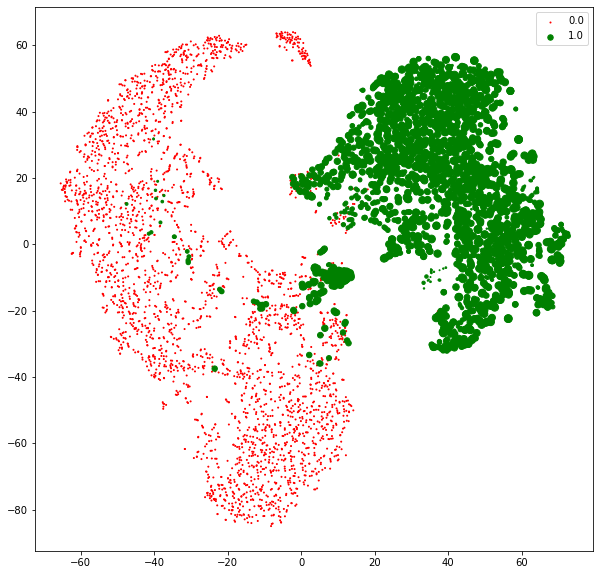

In [161]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 10))
colors = 'r', 'g',
for i, c, label in zip(range(2), colors, np.unique(all_labels)):
    plt.scatter(embedding[all_labels == i, 0], embedding[all_labels == i, 1], c=c, s = all_times[all_labels == i], label=label)
plt.legend()
plt.show()

In [65]:
all_outputs = []
all_labels = []
    
for batch, labels in test_loader:
    batch = batch.to(device)
    r_out, _ = model_LSTM_bce.lstm(batch)
    r_out = r_out.contiguous().view(-1, 100)      
    out = model_LSTM_custom.linear_1(r_out)
    all_outputs.extend(r_out.detach().cpu().numpy())
    all_labels.extend(labels)

In [66]:
#all_outputs = np.concatenate(all_outputs, 0)
all_labels = np.concatenate(all_labels, 0)


In [67]:
from sklearn.manifold import TSNE
embedding = TSNE(n_components=2).fit_transform(all_outputs)

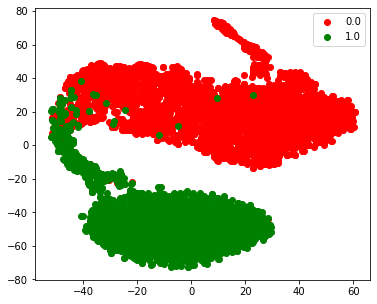

In [68]:
from matplotlib import pyplot as plt
plt.figure(figsize=(6, 5))
colors = 'r', 'g',
for i, c, label in zip(range(2), colors, np.unique(all_labels)):
    plt.scatter(embedding[all_labels == i, 0], embedding[all_labels == i, 1], c=c, label=label)
plt.legend()
plt.show()

In [ ]:
all_outputs = []
all_labels = []
    
for batch, labels in test_loader:
    batch = batch.to(device)
    r_out, _ = model_LSTM_custom.lstm(batch)
    all_outputs.extend(r_out.detach().cpu().numpy())
    all_labels.extend(labels)